## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'bank', 'meps19', 'grade', 'law_sex', 'german_age', 'german_foreign'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "german_foreign"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [4]:
dataset_orig.features.shape

NameError: name 'dataset_orig' is not defined

In [12]:
privileged_groups

[{'foreign': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[1.8000e+01 1.4450e+03 4.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.4000e+01 1.9010e+03 4.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [3.0000e+01 1.0623e+04 3.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.4000e+01 1.2870e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.4000e+01 7.1700e+02 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.4000e+01 3.7770e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]]


In [14]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights features                \
                                                         
                                   month credit_amount   
instance names                                           
282                         1.0     18.0        1445.0   
279                         1.0     24.0        1901.0   
205                         1.0     30.0       10623.0   
26                          1.0      6.0         426.0   
245                         1.0     24.0        1258.0   
...                         ...      ...           ...   
427                         1.0     18.0        1149.0   
454                         1.0     24.0        4817.0   
437                         1.0     24.0        1287.0   
798                         1.0     24.0         717.0   
183                         1.0     24.0        3777.0   

                                                                      \
                                                         

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[2.4000e+01 1.9010e+03 4.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [3.6000e+01 5.3710e+03 3.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [6.0000e+01 1.4027e+04 4.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [6.0000e+01 6.5270e+03 4.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [3.0000e+01 4.5830e+03 2.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.4000e+01 5.8040e+03 4.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]
no bias type specified
#### Training Dataset shape
(500, 56)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['foreign']
#### Privileged and unprivileged protected groups
[{'foreign': 1}] [{'foreign': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'foreign', 'status=A11', 'status=

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 150
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 338
Number of test samples (ntest): 329
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 1
Number of test samples (ntest): 3
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 15
Number of test samples (ntest): 18
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.67
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.29
  Positive predictive value: 0.61
  Optimal thershold: -1.203972804325936
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 147, Test = 153
  AUC: 0.77
  Privacy Risk: 0.76
  Accuracy: 0.76
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.52
  Positive predictive value: 0.68
  Opti

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       147
         1.0       0.95      0.99      0.97       353

    accuracy                           0.96       500
   macro avg       0.96      0.93      0.95       500
weighted avg       0.96      0.96      0.96       500

Train accuracy:  0.956
Validating Original ...
Accuracy for threshold: 0.01  is: 0.674
Balanced accuracy is:  0.5714622064003315
Accuracy for threshold: 0.02  is: 0.674
Balanced accuracy is:  0.5714622064003315
Accuracy for threshold: 0.03  is: 0.674
Balanced accuracy is:  0.5714622064003315
Accuracy for threshold: 0.04  is: 0.674
Balanced accuracy is:  0.5714622064003315
Accuracy for threshold: 0.05  is: 0.674
Balanced accuracy is:  0.5714622064003315
Accuracy for threshold: 0.060000000000000005  is: 0.674
Balanced accuracy is:  0.5714622064003315
Accuracy for threshold: 0.06999999

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

y_val_pred_prob:  [[0.91365385]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.08634615]
 [1.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [0.91365385]
 [1.        ]
 [1.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.08634615]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [0.08634615]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.91365385]
 [0.08634615]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [1.        ]
 [0.91365385]
 [0.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.08634615]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.08634615]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [1.        ]
 [0.91365385]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [

Accuracy for threshold: 0.03  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.04  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.05  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.060000000000000005  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.06999999999999999  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.08  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.09  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.09999999999999999  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.11  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.12  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.13  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.14  is: 0.696
Balanced acc

Accuracy for threshold: 0.22  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.23  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.24000000000000002  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.25  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.26  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.27  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.28  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.29000000000000004  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.3  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.31  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.32  is: 0.662
Balanced accuracy is:  0.5917006966130195
Accuracy for threshold: 0.33  is: 0.662
Balanced accuracy is:  0.5917

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

y_val_pred_prob:  [[1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [0.947625]
 [0.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.947625]
 [0.052375]
 [0.052375]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.947625]
 [0.947625]
 [1.      ]
 [0.052375]
 [0.947625]
 [0.      ]
 [0.052375]
 [0.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.947625]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [0.052375]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.052375]
 [1.      ]
 [0.947625]
 [1.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.947625]
 [1.      

Accuracy for threshold: 0.060000000000000005  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.06999999999999999  is: 0.686
Balanced accuracy is:  0.5410160941628633
Accuracy for threshold: 0.08  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.09  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.09999999999999999  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.11  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.12  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.13  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.14  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.15000000000000002  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.16  is: 0.696
Balanced accuracy is:  0.5927616302346065
Accuracy for threshold: 0.17  is: 0.6

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 160
Number of test samples (ntest): 136
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 317
Number of test samples (ntest): 350
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 2
Number of test samples (ntest): 2
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 21
Number of test samples (ntest): 12
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 500, Test = 500
  AUC: 0.66
  Privacy Risk: 0.66
  Accuracy: 0.66
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.32
  Positive predictive value: 0.60
  Optimal thershold: -0.6931471805599453
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 162, Test = 138
  AUC: 0.77
  Privacy Risk: 0.76
  Accuracy: 0.78
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.52
  Positive predictive value: 0.72
  Opt

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

y_val_pred_prob:  [[1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [0.947625]
 [0.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.947625]
 [0.052375]
 [0.052375]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.947625]
 [0.947625]
 [1.      ]
 [0.052375]
 [0.947625]
 [0.      ]
 [0.052375]
 [0.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.947625]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [0.052375]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.052375]
 [1.      ]
 [0.947625]
 [1.      ]
 [1.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.      ]
 [1.      ]
 [1.      ]
 [0.      ]
 [0.947625]
 [1.      

## Display Output

In [18]:
priv_metric_orig_copy = priv_metric_orig

In [19]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 62.0, 'total_unpriv': 1438.0})

In [20]:
priv_metric_orig

defaultdict(float, {'total_priv': 62.0, 'total_unpriv': 1438.0})

In [21]:
priv_metric_orig = priv_metric_orig_copy

1)

german_foreign
500
2)

              total_priv  total_unpriv
num_instance                          
orig           20.666667    479.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.686000       0.314000    0.921196      0.078804      0.675829   
transf      0.921165       0.078835    0.921196      0.078804      0.921164   

         unpriv_unfavor  
dataset                  
orig           0.324171  
transf         0.078836  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.620864      -0.031325  0.093393      -0.073229   
dt_syn                     0.594922      -0.023409  0.105591      -0.083655   
dt_dir                     0.616007       0.012930  0.088316      -0.023578   
dt_rew                     0.609

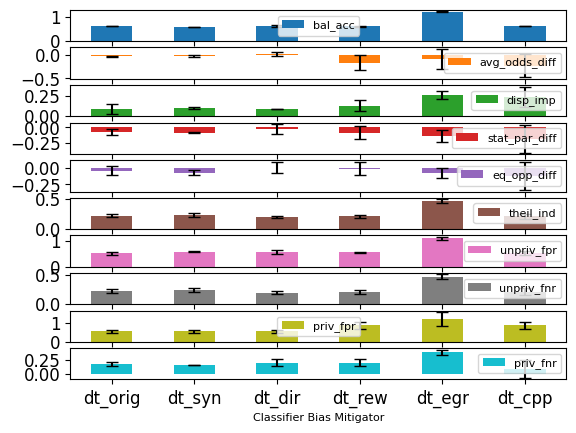

In [22]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

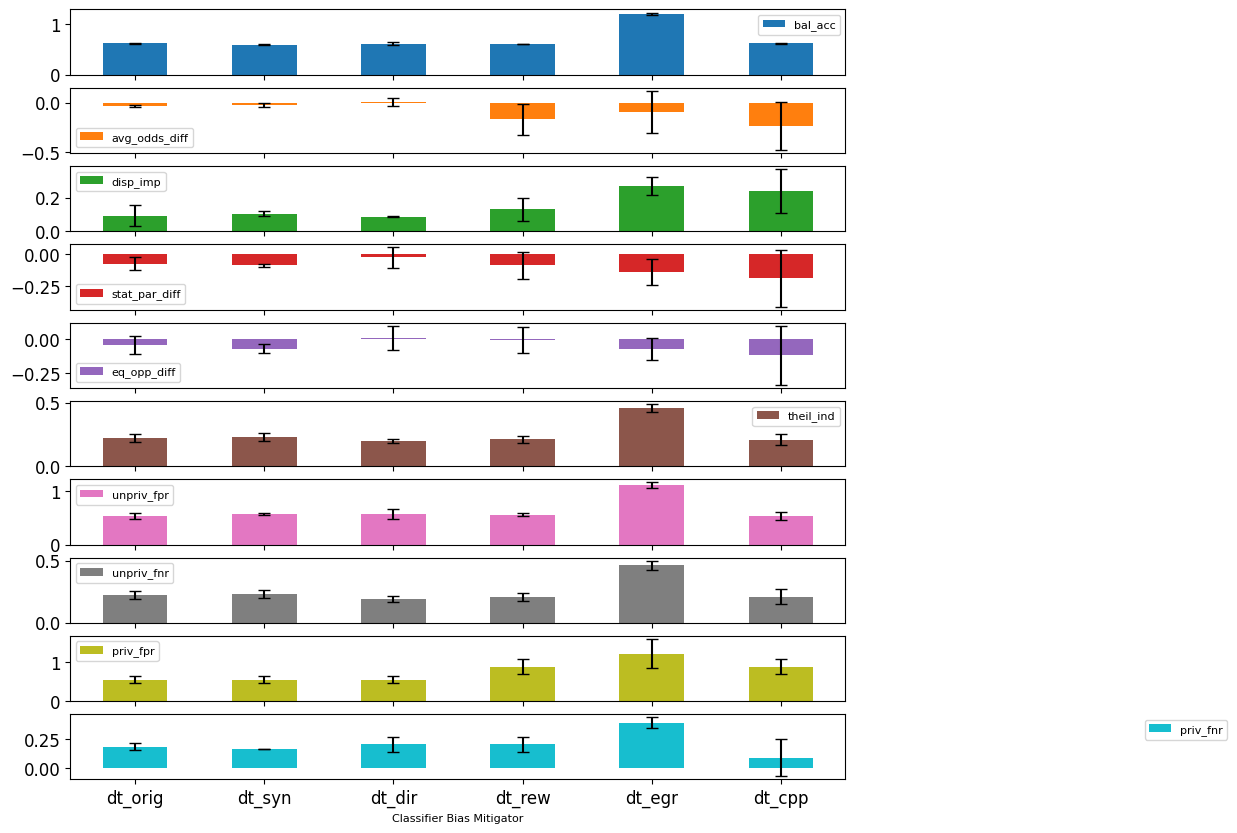

In [23]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [24]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.620864,-0.031325,0.093393,-0.073229,-0.040428,0.221543,0.533333,0.225613,0.555556,0.185185
dt_syn,0.594922,-0.023409,0.105591,-0.083655,-0.068713,0.231090,0.577451,0.235380,0.555556,0.166667
dt_dir,0.616007,0.012930,0.088316,-0.023578,0.008932,0.198053,0.572484,0.194772,0.555556,0.203704
dt_rew,0.609596,-0.164946,0.131952,-0.085055,-0.006428,0.211162,0.565425,0.210132,0.888889,0.203704
dt_egr,1.210045,-0.088750,0.268075,-0.140276,-0.073644,0.456514,1.118366,0.462533,1.222222,0.388889
dt_cpp,0.621088,-0.231640,0.242068,-0.186991,-0.118836,0.208866,0.544444,0.211429,0.888889,0.092593


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [25]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [26]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.644333,0.742765,0.608351,0.744358,0.608355,0.777778,0.630423
syn,0.657667,0.761749,0.617489,0.761585,0.617811,0.777778,0.612963
dir,0.653000,0.759454,0.613041,0.759273,0.612327,0.777778,0.620370
rew,0.651000,0.752217,0.614140,0.749366,0.615097,0.944444,0.613492
egr,0.646333,0.739261,0.613003,0.740796,0.612685,0.777778,0.639683


In [27]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [28]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [29]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.744358,0.608355,0.777778,0.630423
syn,0.761585,0.617811,0.777778,0.612963
dir,0.759273,0.612327,0.777778,0.620370
rew,0.749366,0.615097,0.944444,0.613492
egr,0.740796,0.612685,0.777778,0.639683


<Axes: xlabel='Classifier MIA Attacks'>

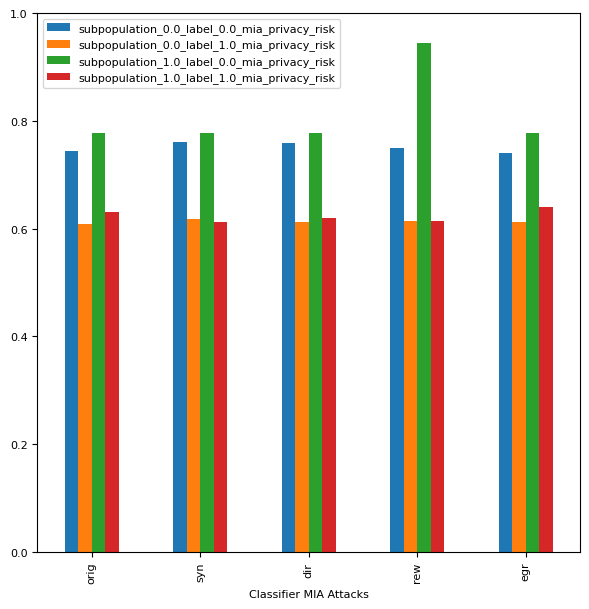

In [30]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [31]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.744358  0.761585  0.759273  0.749366  0.740796
subpopulation_0.0_label_1.0_mia_privacy_risk  0.608355  0.617811  0.612327  0.615097  0.612685
subpopulation_1.0_label_0.0_mia_privacy_risk  0.777778  0.777778  0.777778  0.944444  0.777778
subpopulation_1.0_label_1.0_mia_privacy_risk  0.630423  0.612963  0.62037   0.613492  0.639683


### Visualizing using novel technique

In [32]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [33]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [34]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.643000
1,orig,entire_dataset_mia_privacy_risk,0.645000
2,orig,entire_dataset_mia_privacy_risk,0.645000
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.760771
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.733763
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.750000
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.750000
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.716667
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.601190


In [35]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.643000
1,orig,entire_dataset_mia_privacy_risk,0.645000
2,orig,entire_dataset_mia_privacy_risk,0.645000
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.759543
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.736765
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.750000
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.750000
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.716667
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.601190


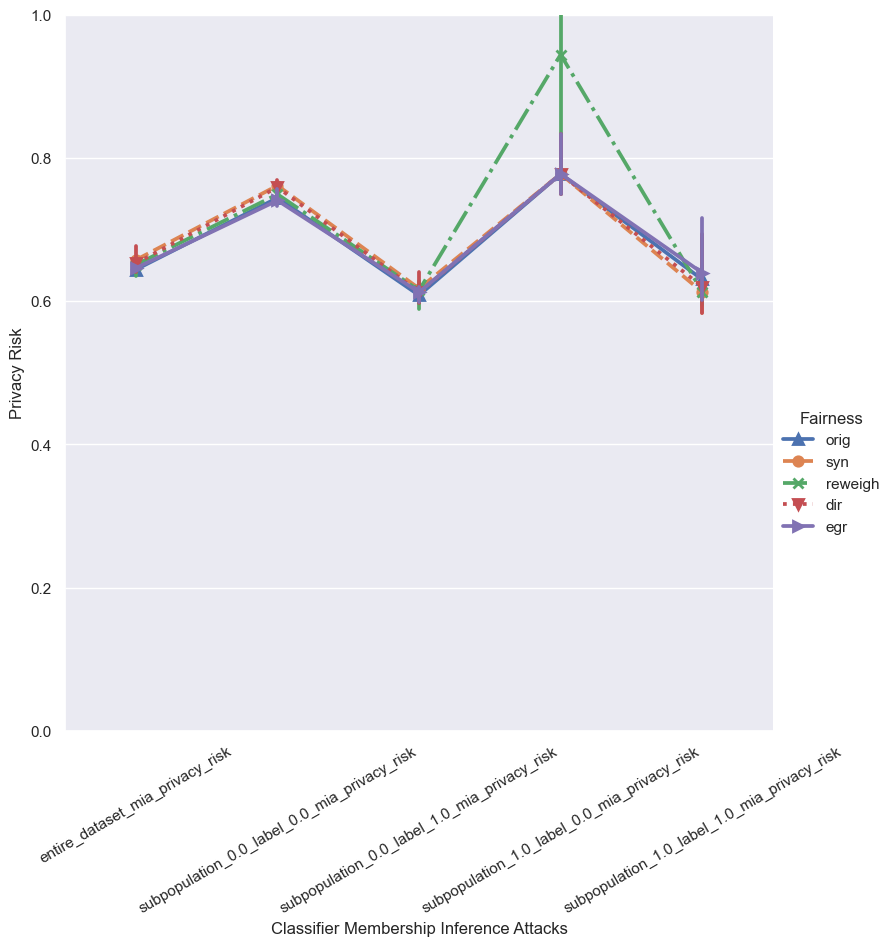

In [36]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [37]:
from sklearn.metrics import RocCurveDisplay, auc

In [38]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

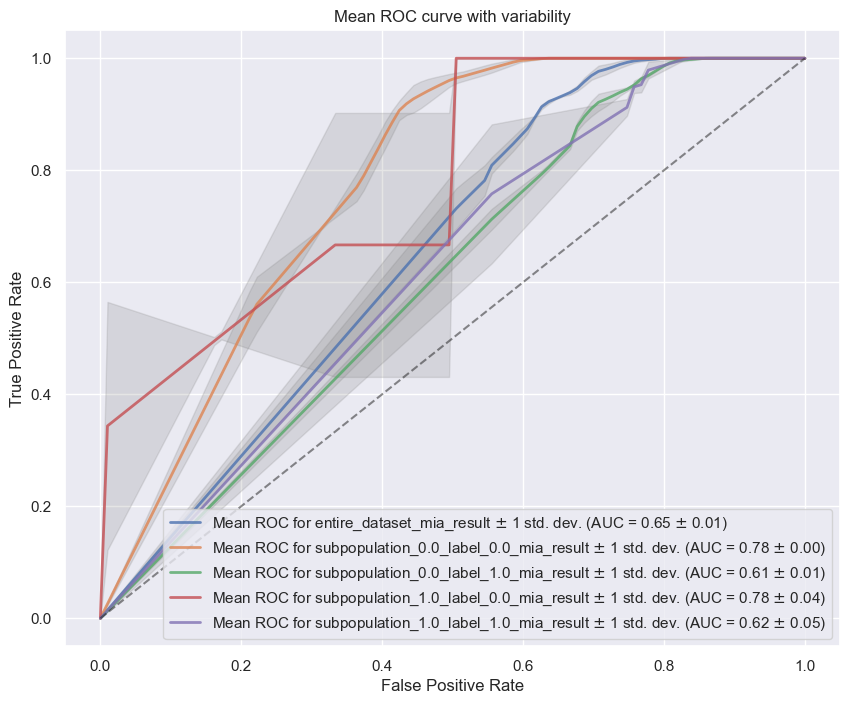

In [39]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

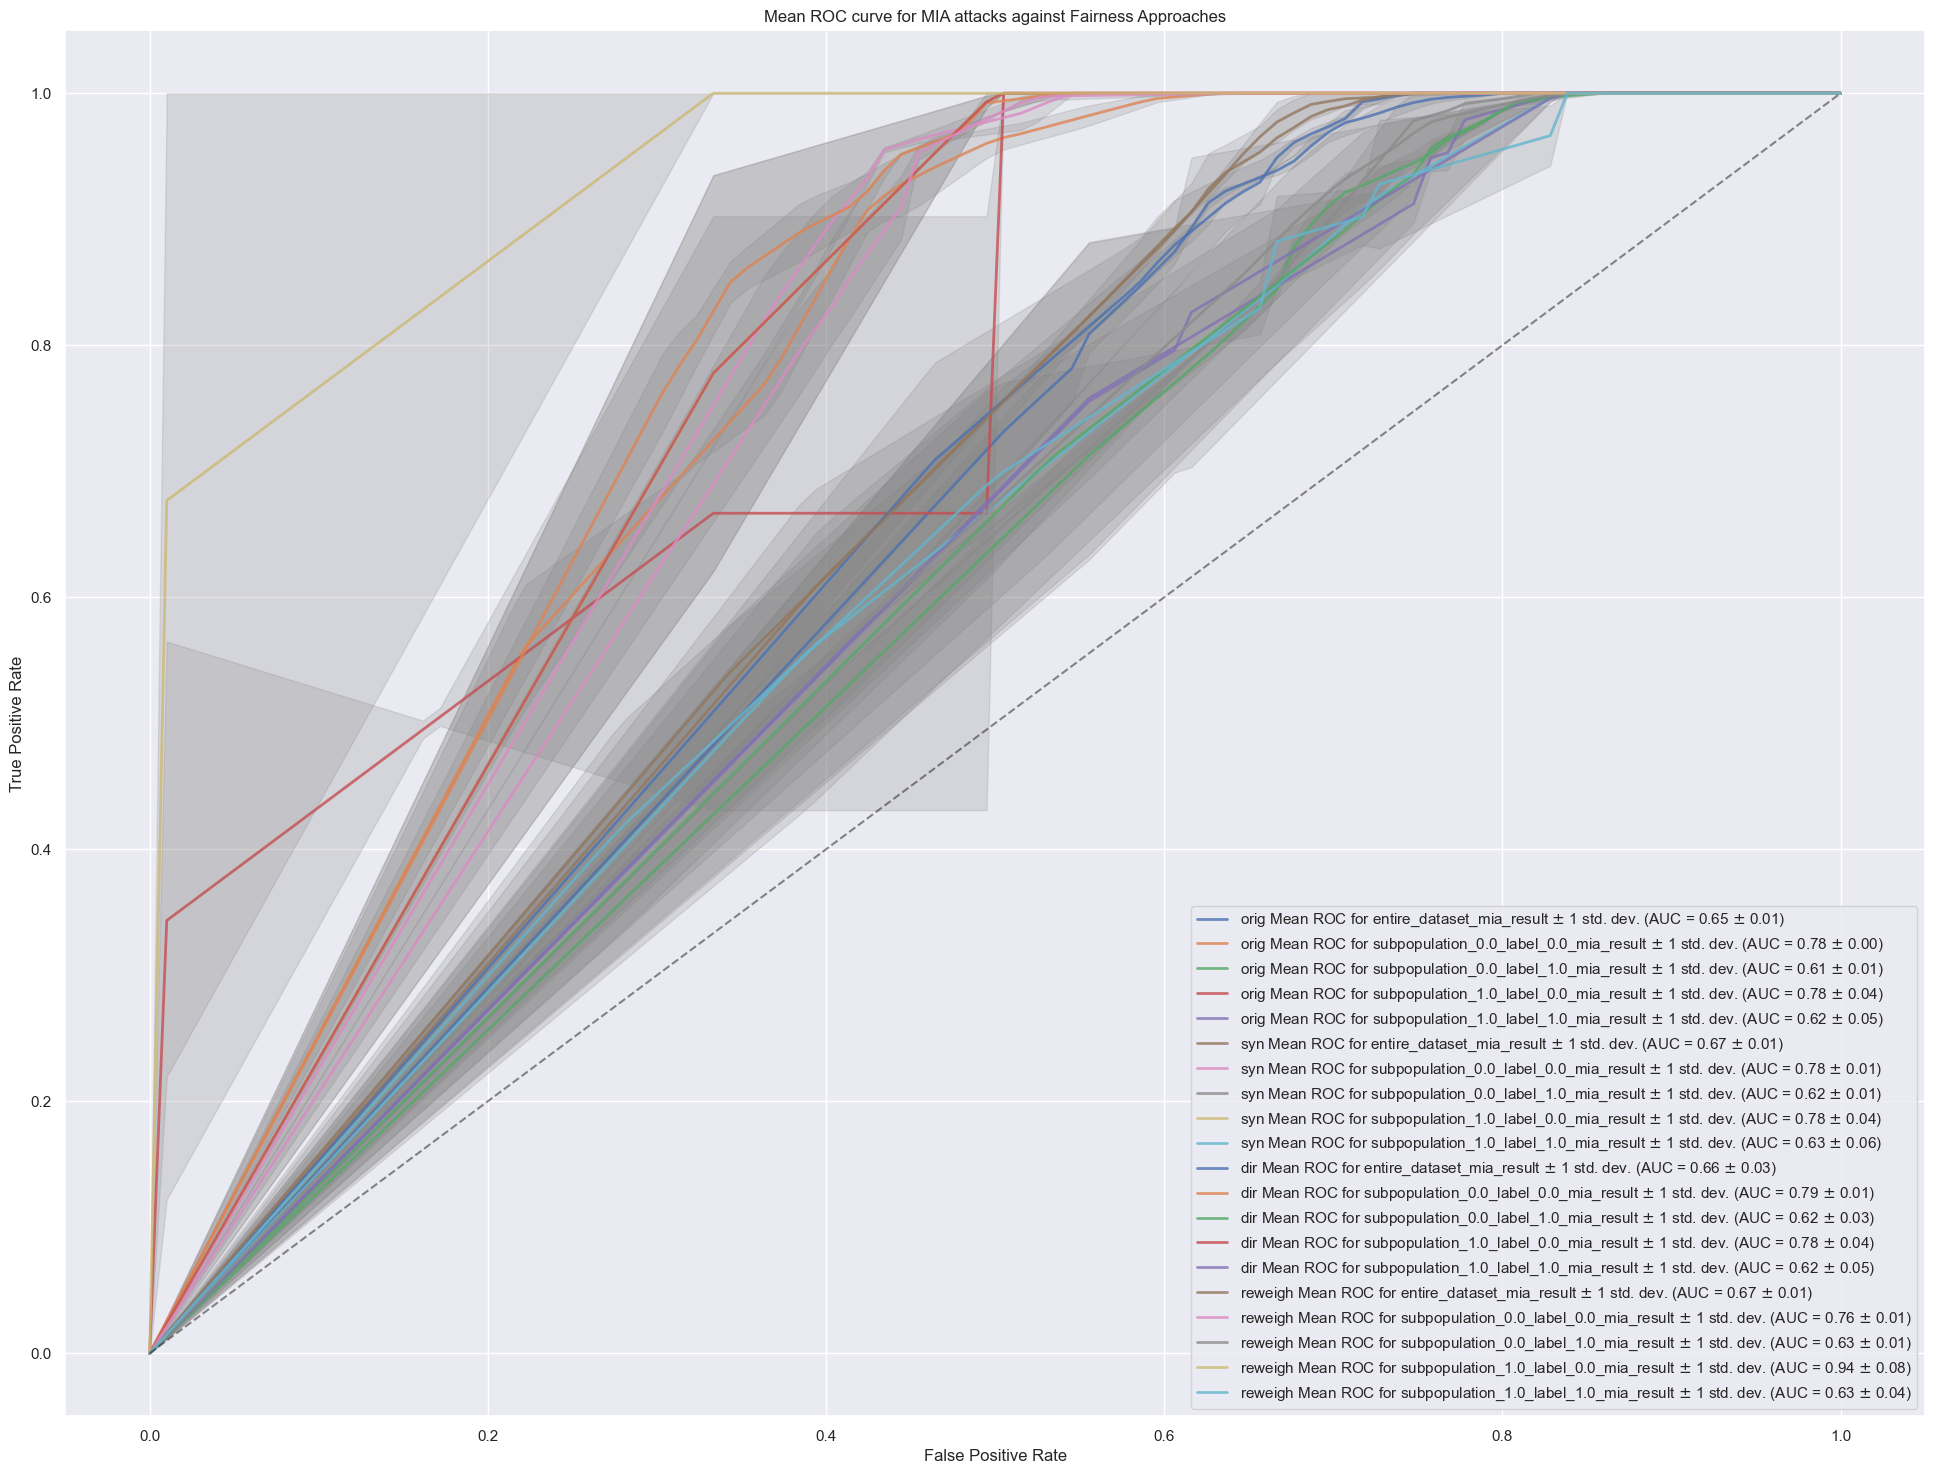

In [40]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

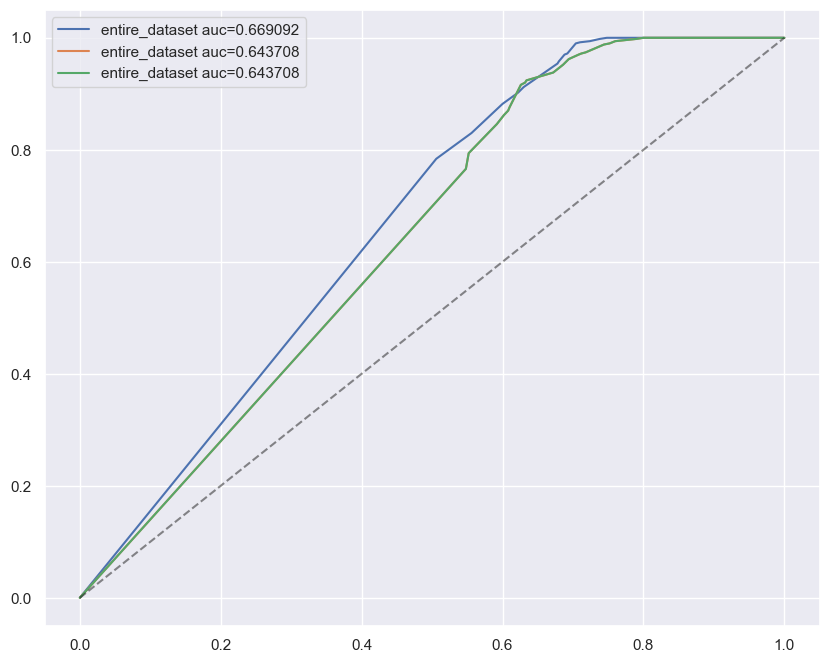

In [41]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [42]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [43]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.6521693333333333,
 'entire_dataset_label_0.0_mia_auc': 0.777252375274676,
 'entire_dataset_label_1.0_mia_auc': 0.6095556346298785,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7764021230638374,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6084413769725638,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7777777777777778,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6211640211640211}

In [44]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.652169,0.777252,0.609556,0.776402,0.608441,0.777778,0.621164
syn,0.668346,0.774915,0.616975,0.775010,0.615948,0.777778,0.625397
dir,0.663826,0.791975,0.617319,0.792283,0.616310,0.777778,0.622222
rew,0.669704,0.759946,0.629767,0.757182,0.629749,0.944444,0.630511


<Axes: xlabel='Classifier MIA Attacks'>

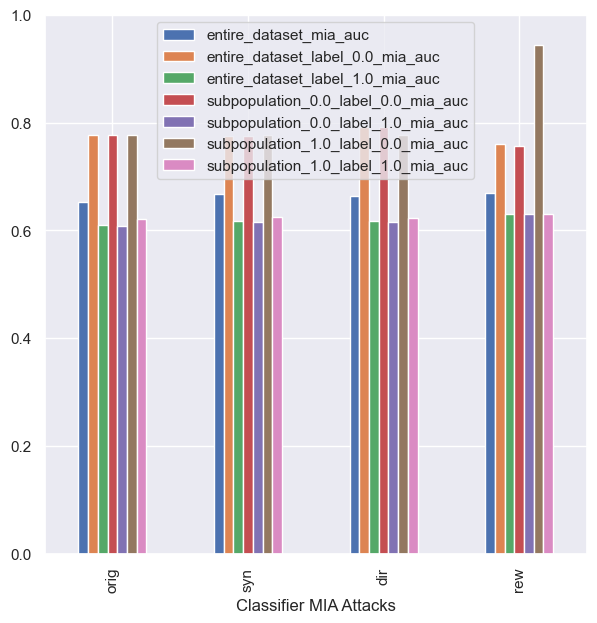

In [45]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [46]:
# Creating data structures to plot point categorical plot from seaborn

In [47]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [48]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.28600000000000003,
  0.29000000000000004,
  0.29000000000000004],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.5215419501133787,
  0.4675254965110037,
  0.4675254965110037],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.195042901111102,
  0.227532773219131,
  0.227532773219131],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.5190867579908676,
  0.4735294117647059,
  0.4735294117647059],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.19464577975216268,
  0.22774222622803064,
  0.22774222622803064],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.6666666666666667,
  0.5,
  0.5],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.37777777777777777,
  0.20238095238095233,
  0.20238095238095233]}

In [49]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.28600000000000003],
 ['orig', 'entire_dataset', 0.29000000000000004],
 ['orig', 'entire_dataset', 0.29000000000000004],
 ['orig', 'entire_dataset_label_0.0', 0.5215419501133787],
 ['orig', 'entire_dataset_label_0.0', 0.4675254965110037],
 ['orig', 'entire_dataset_label_0.0', 0.4675254965110037],
 ['orig', 'entire_dataset_label_1.0', 0.195042901111102],
 ['orig', 'entire_dataset_label_1.0', 0.227532773219131],
 ['orig', 'entire_dataset_label_1.0', 0.227532773219131],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5190867579908676],
 ['orig', 'subpopulation_0.0_label_0.0', 0.4735294117647059],
 ['orig', 'subpopulation_0.0_label_0.0', 0.4735294117647059],
 ['orig', 'subpopulation_0.0_label_1.0', 0.19464577975216268],
 ['orig', 'subpopulation_0.0_label_1.0', 0.22774222622803064],
 ['orig', 'subpopulation_0.0_label_1.0', 0.22774222622803064],
 ['orig', 'subpopulation_1.0_label_0.0', 0.6666666666666667],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5],
 ['orig', 'subp

In [63]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.607752
1,orig,entire_dataset,0.594034
2,orig,entire_dataset,0.594034
3,orig,entire_dataset_label_0.0,0.682051
4,orig,entire_dataset_label_0.0,0.761905
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,1.000000
101,egr,subpopulation_1.0_label_0.0,1.000000
102,egr,subpopulation_1.0_label_1.0,0.608696
103,egr,subpopulation_1.0_label_1.0,0.689655


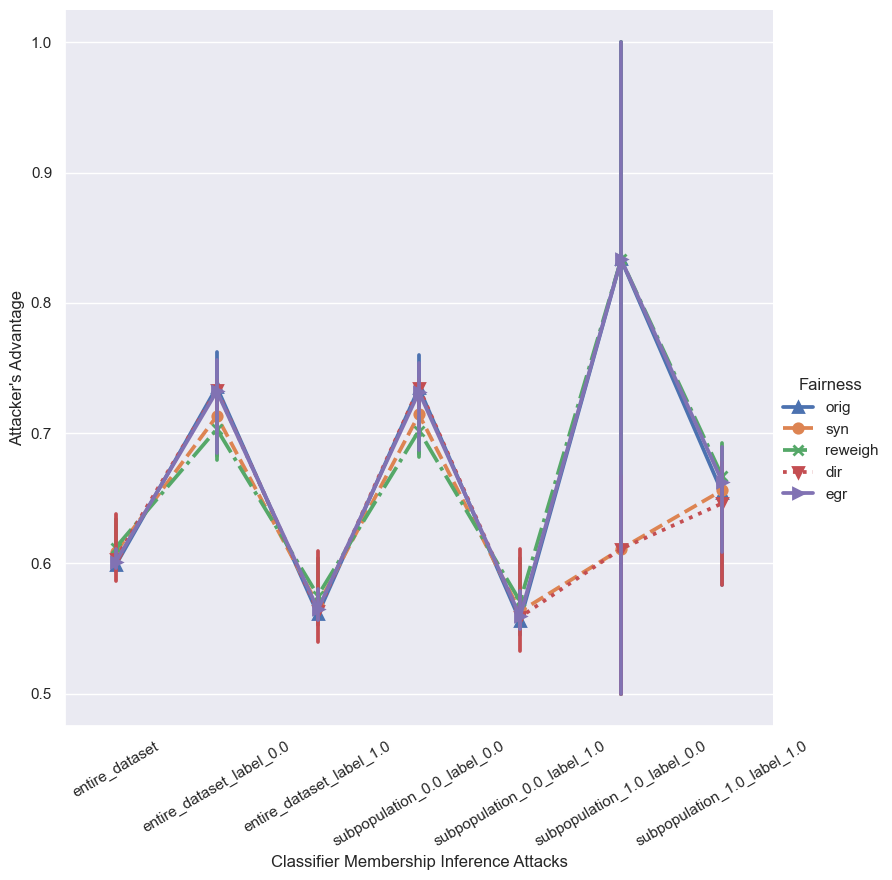

In [64]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


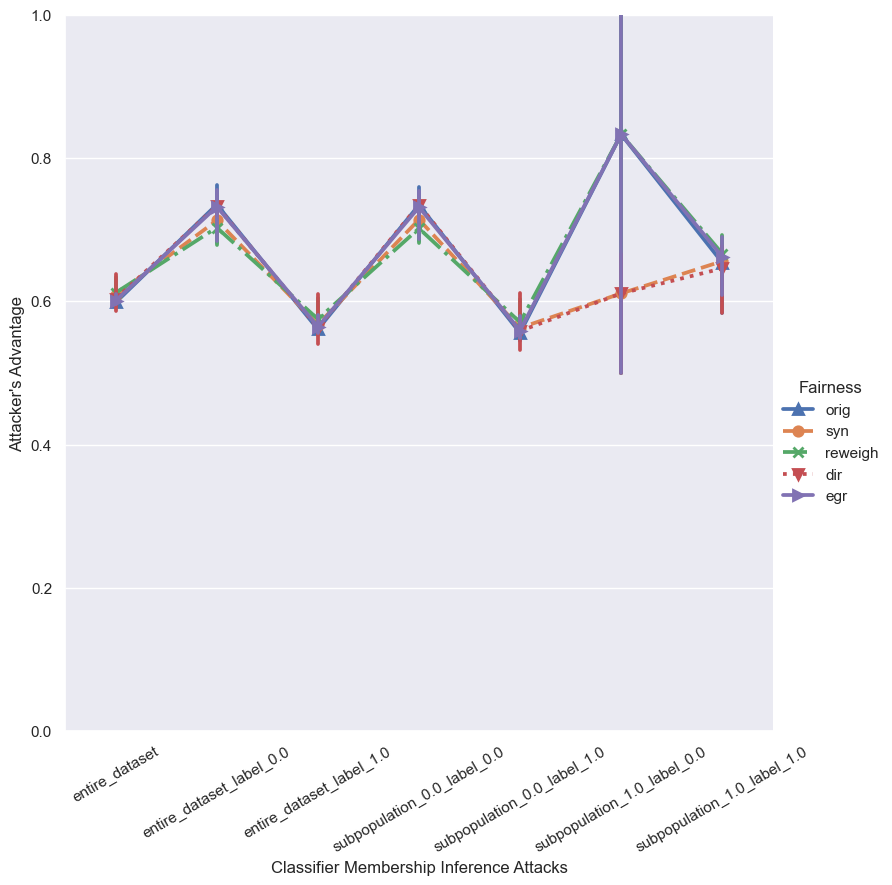

In [67]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [68]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_ppv,entire_dataset_label_0.0_mia_ppv,entire_dataset_label_1.0_mia_ppv,subpopulation_0.0_label_0.0_mia_ppv,subpopulation_0.0_label_1.0_mia_ppv,subpopulation_1.0_label_0.0_mia_ppv,subpopulation_1.0_label_1.0_mia_ppv
0,0.607752,0.682051,0.577681,0.683938,0.577367,0.5,0.583333
1,0.594034,0.761905,0.552632,0.760000,0.545287,1.0,0.689655
2,0.594034,0.761905,0.552632,0.760000,0.545287,1.0,0.689655


In [69]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [70]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.2886666666666667,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.4855309810451287,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.216702815849788,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.48871519384009315,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.2167100774027413,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.5555555555555556,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.2608465608465608}

In [71]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.288667,0.485531,0.216703,0.488715,0.216710,0.555556,0.260847
syn,0.315333,0.523497,0.234977,0.523170,0.235623,0.555556,0.225926
dir,0.306000,0.518909,0.226082,0.518546,0.224654,0.555556,0.240741
rew,0.302000,0.504434,0.228280,0.498732,0.230194,0.888889,0.226984
egr,0.292667,0.478521,0.226007,0.481591,0.225369,0.555556,0.279365


<Axes: xlabel='Classifier MIA Attacks'>

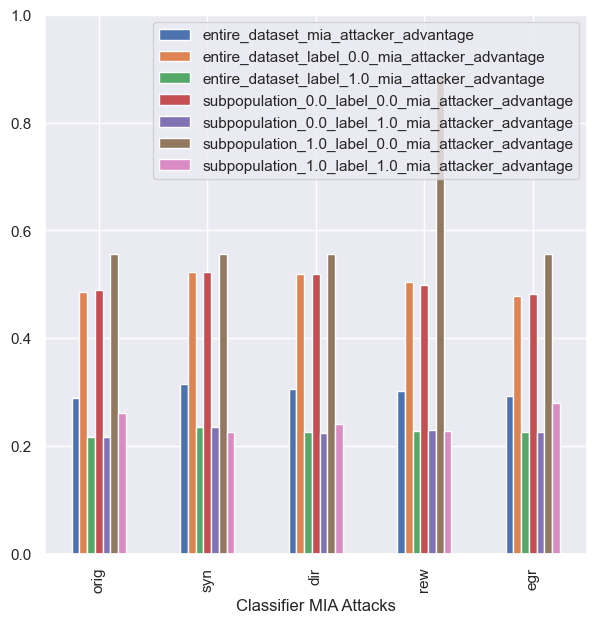

In [72]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [73]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [74]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.6077519379844961],
 ['orig', 'entire_dataset', 0.5940337224383917],
 ['orig', 'entire_dataset', 0.5940337224383917],
 ['orig', 'entire_dataset_label_0.0', 0.6820512820512821],
 ['orig', 'entire_dataset_label_0.0', 0.761904761904762],
 ['orig', 'entire_dataset_label_0.0', 0.761904761904762],
 ['orig', 'entire_dataset_label_1.0', 0.5776805251641138],
 ['orig', 'entire_dataset_label_1.0', 0.5526315789473685],
 ['orig', 'entire_dataset_label_1.0', 0.5526315789473685],
 ['orig', 'subpopulation_0.0_label_0.0', 0.6839378238341969],
 ['orig', 'subpopulation_0.0_label_0.0', 0.76],
 ['orig', 'subpopulation_0.0_label_0.0', 0.76],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5773672055427251],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5452865064695009],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5452865064695009],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5],
 ['orig', 'subpopulation_1.0_label_0.0', 1.0],
 ['orig', 'subpopulation_1.0_label_0.0', 1.0],
 ['orig', 'subpo

In [75]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.607752
1,orig,entire_dataset,0.594034
2,orig,entire_dataset,0.594034
3,orig,entire_dataset_label_0.0,0.682051
4,orig,entire_dataset_label_0.0,0.761905
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,1.000000
101,egr,subpopulation_1.0_label_0.0,1.000000
102,egr,subpopulation_1.0_label_1.0,0.608696
103,egr,subpopulation_1.0_label_1.0,0.689655


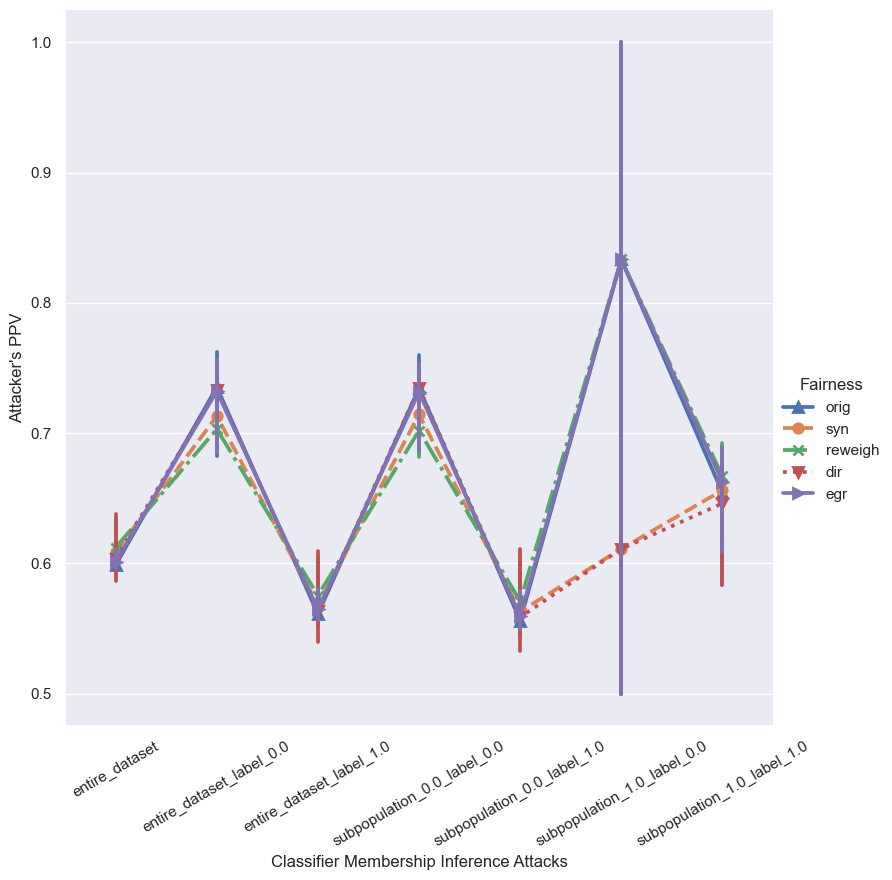

In [76]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [77]:
import pandas as pd

In [78]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,foreign,status=A11,status=A12,...,housing=A151,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,labels
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,31.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
997,12.0,804.0,4.0,4.0,38.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,23.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [79]:
df[["age", "labels"]].value_counts(normalize=True)

age   labels
27.0  1.0       0.038
26.0  1.0       0.036
35.0  1.0       0.034
36.0  1.0       0.033
30.0  1.0       0.029
                ...  
68.0  1.0       0.001
70.0  1.0       0.001
74.0  0.0       0.001
19.0  1.0       0.001
19.0  0.0       0.001
Name: proportion, Length: 100, dtype: float64

In [80]:
df.drop_duplicates()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,foreign,status=A11,status=A12,...,housing=A151,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,labels
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,31.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
997,12.0,804.0,4.0,4.0,38.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,23.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
